# Projet NLP - Groupe 1 - Nohossat, Valérie, Williams

## Consignes

Vous venez d'ouvrir un hôtel. Comme vous n'êtes pas sûr de la qualité de votre établissement, vous permettez aux personnes de poster des commentaires mais pas de mettre de note. Cependant, vous voulez quand même déterminer si le commentaire est positif ou négatif.  

Pour cela, vous allez scrapper des commentaires sur booking et leur note associée afin de faire tourner un algorithme de classification pour faire des prédictions sur vos propres commentaires.

## Application

https://projetnlp.herokuapp.com/

## 1 - Récuperation des données

Site de référence : https://www.booking.com

### Contraintes du scraping

On a récupéré les commentaires des hôtels de plusieurs villes françaises telles que **Paris, Marseille, Lyon, etc...**  

Booking ne permet pas d'ouvrir la page d'un hôtel dans le même onglet donc on a procédé en 2 temps :

- Récupération des liens vers les hôtels avec des commentaires (on ignore ceux qui n'ont aucun commentaire)
- Récupération des commentaires pour chaque hôtel présélectionné

Cette démarche nous permet de reprendre le scraping en cas de crash puisque les liens vers les hôtels sont sauvegardés avant de passer à la deuxième étape.

<img width="1000px" src='booking.gif' alt='booking_website'>

### Données récupérées

Pour chaque hôtel, on récupère au maximum 300 commentaires et les informations suivantes:

- **NOM** : nom du client ayant laissé le commentaire
- **PAYS** : pays de provenance du client
- **FAVORITE** : est-ce que le client a marqué l'établissement parmi ces favoris ?
- **DATE** : date d'envoi du commentaire
- **TITRE** : titre du commentaire laissé par le client
- **BONS POINTS** : les aspects positifs de l'expérience
- **MAUVAIS POINTS** : les aspects négatifs de l'expérience
- **NOTE** : la note laissée par le client
- **TYPE ETABLISSEMENT**: le type de l'établissement (Appartement, Hôtel, etc..)
- **LIEU** : Ville de l'établissement
- **NOTE ETABLISSEMENT** : note moyenne laissée par l'ensemble des commentateurs

<img width="600px" src='commentaire_booking.png' alt='booking_commentaire'>

### Résilience du scraping

Plusieurs actions ont été mises en place pour rendre le scraping résilient: 

- relance de la page en cas d'apparition du pop-up 'Etes-vous humain?'
- timeout de 4min pour récupérer les 300 commentaires par hôtel
- multiprocessing (1 process par ville)
- backup après chaque commentaire récupéré

### Limites

Lors du preprocessing, on s'est rendu compte qu'il y avait une prédominance des commentaires positifs. Le scraping a donc du être réalisé une deuxième fois pour récupérer seulement les commentaires négatifs.


### Résultats

In [ ]:
# print(f'Récupération de {df.shape[0]} commentaires')

## 2 - Analyse des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from nltk.stem.snowball import FrenchStemmer
from stop_words import get_stop_words
import string
from wordcloud import WordCloud
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import TruncatedSVD
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, auc

# plt.rcParams['text.color'] = 'black'
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]
# needed for tokenization
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# You need the averaged_perceptron_tagger resource to determine the context of a word in a sentence.

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt to /Users/nohossat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nohossat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv("booking_comments.csv", na_values=['None', 'none'], decimal=',', encoding="utf8", escapechar='\\')

In [3]:
df.head(5)

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Hôtel,Paris,8.2
1,Guillaume,France,0.0,2019-06-21 00:00:00,Superbe,Ce client n'a pas laissé de commentaire.,NaN,8.8,Hôtel,Cannes,7.1
2,Isabelle,France,0,2019-09-09 00:00:00,Déçu par rapport aux descriptifs je ne recomma...,petit déjeuner très peu de choix et servis jus...,"Dans la chambre un éclairage plus tamisé,dans ...",5.0,Hôtel,Nantes,8.0
3,Laura,France,0.0,2019-03-01 00:00:00,Bien,Ce client n'a pas laissé de commentaire.,NaN,7.9,Appart'hôtel,Cannes,6.6
4,Anonyme,France,0.0,2019-06-07 00:00:00,Bien,La baignoire sur pieds dans la chambre.. comme...,Le rapport qualité/prix.. Mais bon Paris est P...,7.0,Hôtel,Paris,7.6


In [4]:
print(f'Le dataset a {df.shape[0]} lignes et {df.shape[1]} colonnes.')

Le dataset a 50814 lignes et 11 colonnes.


### Statistiques descriptives

In [5]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,50070,50007,50786,50071,49958,43726,32214,50064.000000,50814,50814,50814.000000
unique,9367,143,4,1235,14382,25709,28947,NaN,12,6,NaN
top,Anonyme,France,0.0,2020-02-16 00:00:00,Passable,Ce client n'a pas laissé de commentaire.,Rien,NaN,Hôtel,Paris,NaN
freq,5023,43017,29267,204,5547,11838,725,NaN,42688,25396,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.497633,NaN,NaN,7.693083
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.277708,NaN,NaN,0.908541
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,3.900000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.600000,NaN,NaN,7.200000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.200000,NaN,NaN,7.900000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.800000,NaN,NaN,8.300000


## Sélection des variables

Notre objectif est de savoir si un commentaire est positif ou négatif.

Dans notre analyse, on partira sur 2 hypothèses pour déterminer la polarité des commentaires:  
   - calcul de la polarité des commentaires récoltés
   - utilisation de la colonne note pour déterminer la polarité (target déjà fourni par Booking)
    
On conservera donc toutes les variables qui constituent le commentaire final et la note associée.
- **TITRE**, 
- **BONS POINTS**
- **MAUVAIS POINTS**
- **NOTE**

In [6]:
data = df.drop(['nom', 'pays', 'favorite', 'date', 'type_etablissement', 'lieu', 'note_etablissement'], axis= 1)

data.head()

,titre,bons_points,mauvais_points,note
0,NaN,NaN,NaN,NaN
1,Superbe,Ce client n'a pas laissé de commentaire.,NaN,8.8
2,Déçu par rapport aux descriptifs je ne recomma...,petit déjeuner très peu de choix et servis jus...,"Dans la chambre un éclairage plus tamisé,dans ...",5.0
3,Bien,Ce client n'a pas laissé de commentaire.,NaN,7.9
4,Bien,La baignoire sur pieds dans la chambre.. comme...,Le rapport qualité/prix.. Mais bon Paris est P...,7.0


## Traitement des valeurs manquantes

In [7]:
data.isna().sum()

titre               856
bons_points        7088
mauvais_points    18600
note                750
dtype: int64

In [8]:
# we delete empty rows
data = data.dropna(how='all')

# we delete the rows where the note is null
# since we have 2 hypothesis that we want to test and removing 750 rows over 50k we still have plenty of data
data = data.loc[data.note.notna()]

# in the titre, bons_points and mauvais points columns we replace nan by empty strings
data = data.fillna('')

data.isna().sum()

titre             0
bons_points       0
mauvais_points    0
note              0
dtype: int64

On décide aussi de retirer les commentaires générés par Booking 

In [9]:
# replace automatic comments by booking by empty strings
commentaires_booking = ["Ce commentaire n'apparaît pas car il ne respecte pas notre charte.", "Ce client n'a pas laissé de commentaire."]
data.bons_points.loc[data.bons_points.isin(commentaires_booking)] = ''
data.mauvais_points.loc[data.mauvais_points.isin(commentaires_booking)] = ''

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(50064, 4)

## Concaténation des colonnes Titre, Bons Points et Mauvais Points

In [10]:
# merge columns
data['review'] = data.titre + ' ' + data.bons_points + ' ' + data.mauvais_points
data = data[['review', 'note']]
data

,review,note
1,Superbe,8.8
2,Déçu par rapport aux descriptifs je ne recomma...,5.0
3,Bien,7.9
4,Bien La baignoire sur pieds dans la chambre.....,7.0
5,Pas content ! Pas grand-chose !\nLit assez con...,4.0
...,...,...
50808,"Bon acceuil, très bon rapport qualité, prix! B...",10.0
50809,Fabuleux Hôtel proche de la Gare Montparnasse...,9.2
50811,Un séjour médiocre La localisation et le perso...,4.0
50812,Arrivé le soir à 22h30 et reparti le lendemain...,9.2


## Proportion de commentaires positifs / négatifs

Pour éviter d'avoir un modèle biaisé, on va observer si les commentaires sont équilibrés en fonction de leur note

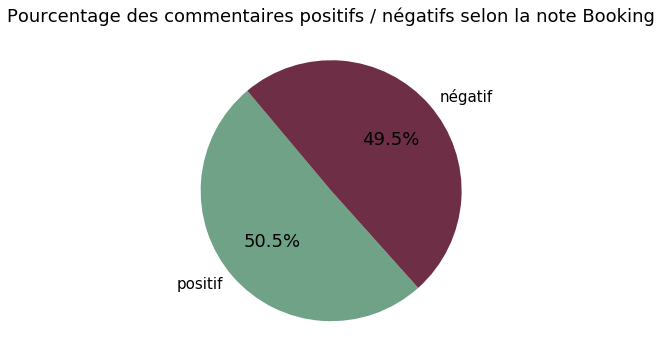

In [11]:
#diagramme circulaire des modalités de la polarité des commentaires
data_percentages = data.note.groupby(data.note > 6).size() / data.shape[0]

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs / négatifs selon la note Booking", fontsize=18)
labels = ['positif', 'négatif']
sizes = [data_percentages[1], data_percentages[0]]

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=130, colors = ['#70A288', '#6D2E46'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

## Comment préparer son dataset dans un projet NLP ?

Pour optimiser notre modélisation, on souhaite **conserver seulement les mots / caractères les plus pertinents pour déterminer la polarité d'un commentaire**. 

4 étapes :

- tokenisation
- retrait des stop words
- lemmatisation
- stemming

### 1 - Tokenisation

Pour faciliter la compréhension du language naturel par la machine, on doit transformer nos chaînes de caractères en tokens.

>**tokens** : mots, ponctuation, symboles

La tokenisation basique consiste à séparer le texte par les espaces et la ponctuation. 

In [12]:
get_review_tokens = (word_tokenize(review) for review in data.review)

### 2 - retrait des stop words

Les conjonctions de coordinations et la ponctuation n'apporte pas d'information pertinente donc pour améliorer la vitesse du modèle on peut les retirer et éviter d'influencer le modèle par leur présence, on les retire. 

In [13]:
def remove_stopwords(review):
    # remove stop words from the review
    stop_words = get_stop_words('french')  
    
    #remove punctuation
    ponctuations = string.punctuation
    p = re.compile(r'\.+')
    
    # remove stop words, ellipsis, punctuation and words which length is below 2, numbers
    review = [p.sub(r'', word) for word in review if word.lower() not in stop_words and word not in ponctuations and not word.isnumeric() and (len(word) > 2 or word == "ne")]
    
    return ' '.join(review)

In [14]:
cleaned_review_tokens = [remove_stopwords(review) for review in get_review_tokens]

### 3 -Normalization : stemmatisation & lemmatization

La normalisation en NLP consiste à conserver la forme canonique des mots du corpus. On peut utiliser deux méthodes : la lemmatization et le stemmatisation

#### Lemmatization 

La lemmatization consiste à analyser le mot selon le contexte d'utilisation et le remplacer par une forme normalisée.

**1 - Etiquetage morpho-syntaxique**

On détermine le contexte d'utilisation grâce à l'étiquetage morpho-syntaxique (Part-Of-Speech - POS Tagging ): on essaye d'attribuer une étiquette (tag) à chaque mot correspondant à sa fonctionnalité grammaticale dans la phrase (nom propre, adjectif, etc...)

Notre lemmatizer utilise les tags du WordNet, donc il faut lier les tags en sortie de la fonction pos_tag à ceux de WordNet (a, n, r, v).

**Part-of-speech tags**

|tag de la fonction pos_tag|tag WordNet| signification |
|-|-|-|
| tags commençant par N | n | nom |
| tags commençant par JJ | a | adjectif |
| tags commençant par V | v | verbe |
| tags commençant par R | r | adverbe |
| les autres tags | N/A | N/A |

Les tags qui n'entrent dans aucune des catégories, ne seront pas considérés par le lemmatizer.

In [15]:
def get_POS(review):
    # pos tag only work if all the element inside the list aren't empty
    review = review.split(' ')
    review = list(filter(None, review))
    return pos_tag(review)

In [16]:
tokens_with_pos = [get_POS(review) for review in cleaned_review_tokens]

In [18]:
def word_lemmatizer(review_with_tag):
    lemmatizer = FrenchLefffLemmatizer()
    
    lem_text = []
    
    for word, pos in review_with_tag:
        if pos.startswith('N'):
            normalized_word = lemmatizer.lemmatize(word, 'n') 
        elif pos.startswith('JJ'):
            normalized_word = lemmatizer.lemmatize(word, 'a') 
        elif pos.startswith('V'):
            normalized_word =  lemmatizer.lemmatize(word, 'v') 
        elif pos.startswith('R'):
            normalized_word = lemmatizer.lemmatize(word, 'r') 
        else :
            normalized_word = lemmatizer.lemmatize(word) 
        
        lem_text.append(normalized_word)
            
    return lem_text

In [ ]:
normalized_review_tokens = [word_lemmatizer(review) for review in tokens_with_pos]

Le lemmatisation est une opération chronophage, les résultats étant tout de même satisfaisants sans cette étape, nous avons décider de ne pas l'inclure dans notre preprocessing. Nous nous contenterons du stemming, opération beaucoup plus rapide.

#### Stemmatisation

Pour éviter d'inclure les variations d'un mot dans notre corpus (ex: vouloir : veux, voulons, veuille, etc..), on va récuperer le radical du mot.

In [ ]:
def stem_review(review):
    stem = FrenchStemmer()
    # review = review.split(' ')
    return [stem.stem(word) for word in review]

In [ ]:
normalized_tokens = [stem_review(review) for review in cleaned_review_tokens]

> Nos commentaires sont nettoyés et normalisés

### VISUALISATION : Fréquence des mots et nuage de mots

Pour observer la fréquence des mots, on va utiliser le corpus **cleaned_review_tokens** qui ne comprend pas la normalization et donc nous permet de voir les mots dans leur forme entière.

In [ ]:
# we need to get all words
all_words = np.array(cleaned_review_tokens).flatten()
all_words = ' '.join(all_words).split() 

#calculer les 100 mots les plus fréquents
nb = 100
word_dist = nltk.FreqDist(all_words)

In [ ]:
#affichage dans un dataframe des 7 mots les plus fréquents
word_frequency = pd.DataFrame(word_dist.most_common(nb), columns=['Word', 'Frequency'])
most_frequent = word_frequency.head(10)
most_frequent

In [ ]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
sns.barplot(x="Word",y="Frequency", data=most_frequent)

In [ ]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [ ]:
wcloud(all_words,'black','Common Words')

## Analyse de sentiments

L'analyse de sentiments consiste à déterminer si un commentaire est positif, neutre ou négatif.

### Première approche : calcul de la polarité avec la note Booking

Avec les notes Booking, on va faire la répartition suivante et on récupère le dataset commentaires / polarité: 

0 => 5 : négatif  
sup 5 : positif  

In [ ]:
reviews = np.array([' '.join(review) for review in normalized_tokens])

notes_booking = data.note.copy()
notes_booking.loc[notes_booking < 5] = 0
notes_booking.loc[notes_booking >= 5] = 1

# dataset with preprocessing
dataset_note_booking = pd.DataFrame(data= {'review' : reviews, 'polarite' : notes_booking})
dataset_note_booking.to_csv('dataset_booking_model.csv', index=False)

### Deuxieme approche : calcul de la polarité sur les commentaires

On va utiliser le Pattern Analyzer de TextBlob pour déterminer la polarité d'un commentaire

Une polarité de : 
* \- 1 à 0 : commentaire négatif
* 0 à 1 : commentaire positif

Pour avoir une polarité correcte, on va la calculer sur les tokens sans normalisation (utilisation de la liste **cleaned_review_tokens**)

In [ ]:
# sentiment renvoie un tuple avec la polarité et la subjectivite, on veut récuperer juste la première valeur
polarite = [TextBlob(review, analyzer=PatternAnalyzer()).sentiment[0] for review in cleaned_review_tokens]

#### Datasets avec la polarité

la polarité peut prendre une valeur continue entre -1 et 1. On peut regrouper les valeurs en 2 groupes (0 / 1)
et ne pas tenir compte des commentaires neutres (polarité = 0)

In [ ]:
dataset_polarite = pd.DataFrame({'review': reviews, 'polarite' : polarite})

dataset_polarite = dataset_polarite.loc[dataset_polarite['polarite'] != 0]
dataset_polarite.loc[dataset_polarite['polarite'] < 0] = 0
dataset_polarite.loc[dataset_polarite['polarite'] > 0] = 1

# dataset with preprocessing
dataset_polarite.to_csv('dataset_polarite.csv', index=False)

### Corrélation entre les notes Booking et la polarité calculée

Calculons la répartition des commentaires positifs / négatifs selon la polarité obtenue avec TextBlob

In [ ]:
#diagramme circulaire des modalités de la polarité des commentaires
data_percentages = dataset_polarite.polarite.value_counts() / dataset_polarite.shape[0]

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs par rapport à la polarié", fontsize=18)
labels = ['positif', 'négatif']
sizes = [data_percentages[1], data_percentages[0]]

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=130, colors = ['#70A288', '#6D2E46'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

#### Matrice de corrélation

In [ ]:
d = {'polarite': polarite, 'note': notes_booking.values}
polarites = pd.DataFrame(data=d)

df_corr = polarites.corr()
sns.heatmap(df_corr, annot=True)

## Analyse comparative des modèles de classification

On va tester plusieurs modèles pour voir celui qui nous sort les meilleurs résultats : 
   - Régression logistique
   - Naive Bayes : ComplementNB, Multinomial
   - Méthodes ensemblistes : XGB, GradientBoosting, RandomForest, AdaBoost
   - SVM
   
### Feature Transformation

La majorité des modèles dans Scikit-Learn ne prennent pas en entrée des chaînes de caractère, il faut transformer nos variables en données numériques au préalable.

Il y a plusieurs méthodes que l'on peut utiliser: 

#### Count Vectorizer

> DEFINITION

#### Tf-idf Transformer

> DEFINITION

#### Truncated SVD

> DEFINITION

## Modélisation

Dans la partie Analyse des données, nous avons détaillé les étapes du preprocessing dans un projet NLP mais on peut aussi les synthétiser dans une Pipeline.  

On partira donc des datasets sans preprocessing : **dataset_polarite_before_nlp_prepro** & **dataset_note_booking_before_nlp_prepro**

In [ ]:
def run_model(db_name, model_name, train_name, model, X_train, y_train, default_params = None, grid_search_params = None):
    '''
    run model with different feature transformations + with or without GridSearch
    '''
    # measures the time taken by the model to run
    start_time = time.time()

    # get model
    if default_params:
        clf = model(**default_params)
    else : 
        clf = model()
    
    # fit model with or without GridSearchCV
    if grid_search_params :
        grid_clf = GridSearchCV(clf, grid_search_params, n_jobs=-1)
        clf = grid_clf.fit(X_train, y_train)
        best_params = clf.best_params_
        print(best_params)
    else:
        clf.fit(X_train, y_train)
        best_params = None
            
    # get predictions
    y_pred = clf.predict(X_train)
    
    # we will record some metrics in a CSV file for presentation
    duration = time.time() - start_time
    accuracy = np.mean(cross_val_score(clf, X_train, y_train, cv=5)) # avg score on the CV
    precision = precision_score(y_train, y_pred, average=None)
    recall = recall_score(y_train, y_pred, average=None)
    f1score = f1_score(y_train, y_pred, average=None)
    results = [[db_name, model_name, train_name, accuracy, precision, recall, f1score, best_params, duration ]]
    
    # save to csv
    cols = ['dataset', 'model_name', 'feature transformation', 'accuracy', 'precision', 'recall', 'f1_score', 'best paramaters', 'duration']
    
    try:
        backup = pd.read_csv('booking_models_metrics.csv')
    except Exception as e:
        print(e)
        backup = pd.DataFrame([], columns=cols)
    
    model_metrics = pd.DataFrame(results, columns=cols)
    
    backup = pd.concat([backup, model_metrics])
    backup.to_csv('booking_models_metrics.csv', index=False)
    
    return backup

In [ ]:
def get_models_results(name_dataset, dataset):
    '''
    for a given dataset, run all predefined models and paramaters and save the results into a CSV file
    '''
    
    # get split data
    X = dataset['review']
    y = dataset['polarite']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # get different types of X_train according to feature transformation
    train_data = {}
    
    # CountVectorizer + Tf-idf
    pipe_tfidf = make_pipeline(CountVectorizer(), TfidfTransformer())
    X_train_tfidf = pipe_tfidf.fit_transform(X_train).toarray()
    train_data['CV + TF-IDF'] = X_train_tfidf
    
    
    # CountVectorizer + N-gram
    pipe_ngram = make_pipeline(CountVectorizer(min_df=0.0005, ngram_range=(1, 2)), TfidfTransformer())
    X_train_ngram = pipe_ngram.fit_transform(X_train).toarray()
    train_data['CV(n-gram) + TF-IDF'] = X_train_ngram
    
    
    # CountVectorizer + Tf-idf Truncated SVD
    pipe_svd_tfidf = make_pipeline(CountVectorizer(), TfidfTransformer(), TruncatedSVD(n_components=300))
    X_train_svd = pipe_svd_tfidf.fit_transform(X_train)
    train_data['CV + TF-IDF + SVD'] = X_train_svd
    
    # list models
    models = {
        'Regression logistique' : LogisticRegression
        'NB : Naive Bayes' : MultinomialNB, 
        'Gradient Boosting ' : GradientBoostingClassifier,
        'Random Forest' : RandomForestClassifier,
        'XGB': XGBClassifier,
        'SVC' : SVC,
        'AdaBoost': AdaBoostClassifier
    }
    
    # related params for GridSearch and random_state
    params = {
        'Regression logistique' : [{'penalty' : ['l1', 'l2']}, {'random_state' : 0}]
        'NB : Naive Bayes' : [ None, None ],
        'Gradient Boosting' : [{'learning_rate' : [0.05, 0.01, 0.2], 
                                'criterion': ["friedman_mse", "mae", "mse"],
                                'n_estimators' : [50, 200],
                                'max_depth': [6, 30, 50]}, {'random_state' : 0}],
        'Random Forest' : [{'boostrap' : [True, False], 
                            'criterion' : ['gini', 'entropy'], 
                            'n_estimators' : [50, 200],
                            'max_depth': [6, 30, 50]}, {'random_state' : 0}], 
        'XGB': [{'learning_rate' : [0.05, 0.01, 0.2],
                 'max_depth' : [6, 30, 50],
                 'n_estimators' : [50, 200]}, {'random_state' : 0}],
        'SVC' : [{ 'C': [1, 5, 10, 50],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005],
                 'kernel': ['rbf','sigmoid']}, 
                 {'random_state' : 0}],
        'AdaBoostClassifier' : [ {'base_estimator' : [MultinomialNB, SVC],
                                  'n_estimators' : [50, 200]}, 
                                {'random_state' : 0}]
    }
    
    
    # run models with different parameters and different feature extraction methods
    for name_model, model in models.items():
        for name_X_train, X_train in train_data.items():
            print(name_dataset, name_X_train, name_model, params[name_model][0], params[name_model][1])
            try : 
                run_model(name_dataset, 
                          name_model, 
                          name_X_train, 
                          model, 
                          X_train, 
                          y_train, 
                          default_params = params[name_model][1], 
                          grid_search_params = params[name_model][0])
            except Exception as e:
                print(e)
            print('done')

In [ ]:
# test with one model + feature transformation Count Vectorizer + tf-idf
X = dataset_note_booking['review']
y = dataset_note_booking['polarite']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
pipe_tfidf = make_pipeline(CountVectorizer(), TfidfTransformer())
X_train_tfidf = pipe_tfidf.fit_transform(X_train).toarray()

run_model('note_booking', 
          'multinomial', 
          'cv + tf-idf', 
          LogisticRegression, 
          X_train_tfidf, 
          y_train, 
          default_params = {'random_state' : 0}, 
          grid_search_params = {'penalty' : ['l1', 'l2']})

In [ ]:
# on récupère tous les modèles et leurs métriques dans le fichier CSV booking_models_metrics.csv
get_models_results('note_booking', dataset_note_booking)

In [ ]:
get_models_results('note_polarite', dataset_polarite)

## 4 - Résultats et Evaluation

Mettre le CSV obtenu après l'entraînement des modèles

## 5 - Conclusions et difficultés rencontrées

### Conclusions

TBD

#### Scraping

- **gérer les coupures internet et les code recaptcha** : il faut relancer le process automatiquement après coupure ou lorsqu'un popup 'Etes-vous humain' empêche toute interaction.
- **booking.com ouvre forcément les pages établissement sur un nouvel onglet**: cela ralentit le code puisqu'il faut prendre en compte le temps de latence et les codes intempésitfs de booking (cookie / recaptcha)
- **gérer le multiprocessing** : pour récupérer le plus de données possibles, on a utilisé le multiprocessing. Mais on s'est rendu compte que la gestion des exceptions est ici primordiale parce que malgré les exceptions, le code doit continuer de scraper le site. Ce qui compte c'est d'en scraper le plus possible et non de pouvoir scrapper tous les commentaires existants. 
- **récupération des commentaires négatifs**

### Analyse des données

TBD - Williams ?

### Machine Learning

TBD - Valérie ?

### Création de l'application

L'application Flask nous permet de soumettre un commentaire et de voir la prédiction du modèle trouvé lors de l'étape de Machine Learning. Les commentaires sont sauvegardés dans une base de données.